# vine copula (vinecop)

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `VineCop.fit` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `VineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `VineCop`.

This function can prioritize vertices inside `first_tree_vertex` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `sample_order` attribute inside a `VineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if its opposite upper vertex is not available.

With `first_tree_vertex` given during fitting, the fitted `VineCop` object allows for **conditional simulation**, where `dct_v_s_obs` and `sample_order` can be specified for `.sample()`.


In [1]:
import sys
import platform
import math
import torch
from torch.special import ndtr
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

rho = 0.95
V = torch.randn(size=(10000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(5000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS)
obs_mvcp = V
for _ in range(2):
    obs_mvcp = torch.hstack(
        [
            obs_mvcp,
            torch.hstack(
                [
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [0]].reshape(-1, 1),
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [1]].reshape(-1, 1),
                ]
            ),
        ]
    )
obs_mvcp = obs_mvcp[:1000, :7].to(DEVICE)

Python: 3.12.9 (main, Mar 17 2025, 21:01:58) [Clang 20.1.0 ]
Platform: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.35
PyTorch: 2.7.0+cu126
CUDA available: True


In [2]:
num_step_grid = 32
mdl_vcp = tvc.vinecop.VineCop(
    num_dim=obs_mvcp.shape[1], num_step_grid=num_step_grid, device=DEVICE
)
mdl_vcp.fit(obs_mvcp=obs_mvcp, mtd_vine="rvine", first_tree_vertex=(0, 5))
print(mdl_vcp)

VineCop
'num_dim': 6,
 'num_obs': 1_000,
 'mtd_bidep': 'chatterjee_xi',
 'negloglik': 160.8196,
 'num_step_grid': 32,
 'dtype': torch.float64,
 'device': 'cpu',
 'sample_order': (3, 4, 1, 2, 0, 5),
 'matrix':
    tensor([[ 3,  4,  2,  5,  1,  0],
            [-1,  4,  1,  0,  5,  2],
            [-1, -1,  1,  2,  5,  0],
            [-1, -1, -1,  2,  0,  5],
            [-1, -1, -1, -1,  0,  5],
            [-1, -1, -1, -1, -1,  5]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 1'}>,
 <networkx.classes.graph.Graph at 0x7f56cc15ee10>)

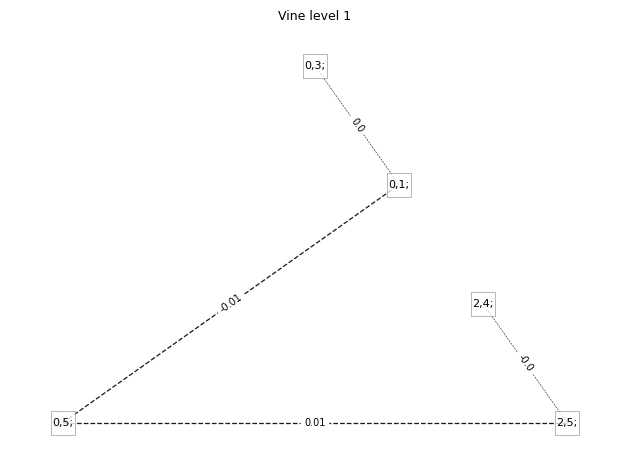

In [3]:
mdl_vcp.draw_lv(lv=1, is_bcp=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine comp graph'}>,
 <networkx.classes.digraph.DiGraph at 0x7f56ced1f260>)

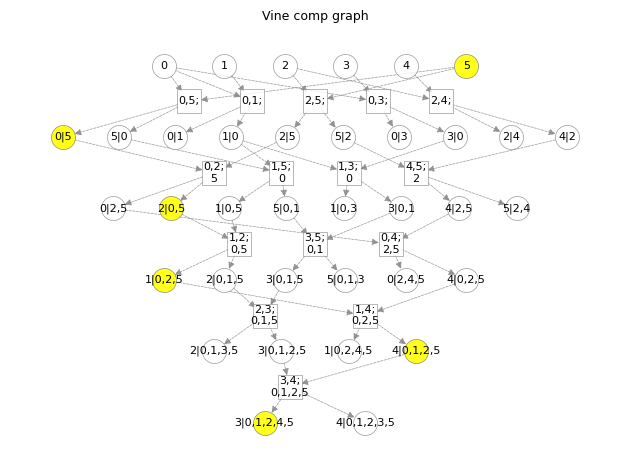

In [4]:
mdl_vcp.draw_dag()

## inside a VineCop obj

- $\frac{D(D-1)}{2}$ bicops (`torch.nn.Module` inside `ModuleDict`)
- parents of bicops
- parents of pseudo-obs
- a `staticmethod` oracle to query the number of h-function calls (and source vertices) given a sampling order on a vine


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_1$', ylabel='$u_2$'>

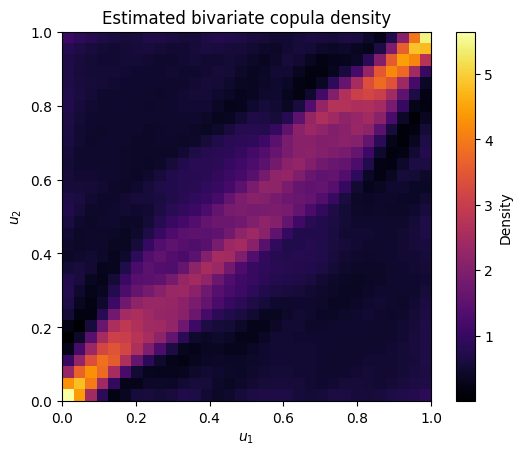

In [5]:
next(iter(mdl_vcp.bicops.values())).imshow()

In [6]:
print(mdl_vcp.bicops, mdl_vcp.struct_bcp, mdl_vcp.struct_obs)
mdl_vcp.ref_count_hfunc(
    num_dim=mdl_vcp.num_dim,
    struct_obs=mdl_vcp.struct_obs,
    sample_order=mdl_vcp.sample_order,
)

ModuleDict(
  (0,1): BiCop()
  (0,2): BiCop()
  (0,3): BiCop()
  (0,4): BiCop()
  (0,5): BiCop()
  (1,2): BiCop()
  (1,3): BiCop()
  (1,4): BiCop()
  (1,5): BiCop()
  (2,3): BiCop()
  (2,4): BiCop()
  (2,5): BiCop()
  (3,4): BiCop()
  (3,5): BiCop()
  (4,5): BiCop()
) {'0,1': {'cond_ed': (0, 1), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,2': {'cond_ed': (0, 2), 'cond_ing': (5,), 'is_indep': False, 'left': '0,5', 'right': '2,5'}, '0,3': {'cond_ed': (0, 3), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,4': {'cond_ed': (0, 4), 'cond_ing': (2, 5), 'is_indep': False, 'left': '0,2', 'right': '4,5'}, '0,5': {'cond_ed': (0, 5), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,2': {'cond_ed': (1, 2), 'cond_ing': (0, 5), 'is_indep': False, 'left': '1,5', 'right': '0,2'}, '1,3': {'cond_ed': (1, 3), 'cond_ing': (0,), 'is_indep': False, 'left': '0,1', 'right': '0,3'}, '1,4': {'cond_ed': (1, 4), 'cond_ing': (0, 2, 5), 'is_indep': False, 'left': '

({(5,): 5,
  (0,): 4,
  (0, 5): 3,
  (2, 5): 3,
  (2, 0, 5): 3,
  (2,): 3,
  (1, 0, 5): 3,
  (1, 0, 2, 5): 2,
  (5, 0): 3,
  (1, 0): 4,
  (1,): 1,
  (4, 0, 2, 5): 2,
  (4, 0, 1, 2, 5): 2,
  (0, 2, 5): 2,
  (4, 2, 5): 2,
  (5, 2): 2,
  (4, 2): 2,
  (4,): 1,
  (3, 0, 1, 2, 5): 2,
  (3, 0, 1, 2, 4, 5): 1,
  (2, 0, 1, 5): 2,
  (3, 0, 1, 5): 2,
  (5, 0, 1): 2,
  (3, 0, 1): 2,
  (3, 0): 2,
  (3,): 1},
 [(5,), (0, 5), (2, 0, 5), (1, 0, 2, 5), (4, 0, 1, 2, 5), (3, 0, 1, 2, 4, 5)],
 6)

## log_pdf, cdf


In [7]:
mdl_vcp.log_pdf(obs_mvcp=obs_mvcp)

tensor([[-4.5560e-01],
        [ 1.0204e-02],
        [-8.7124e-01],
        [ 4.1674e-01],
        [ 7.5425e-02],
        [-8.1338e-01],
        [-2.4337e-02],
        [ 4.7981e-02],
        [-1.8530e-01],
        [-1.5175e-01],
        [ 4.7043e-01],
        [-1.0193e-01],
        [-5.8940e-01],
        [-1.7264e-01],
        [-4.9388e-01],
        [ 1.7839e-01],
        [-5.7505e-01],
        [-3.4391e-02],
        [ 3.1599e-01],
        [-7.2295e-01],
        [-6.2030e-01],
        [-1.4565e+00],
        [-1.1952e+00],
        [-2.4300e-01],
        [-2.6872e-01],
        [ 4.3013e-01],
        [-6.4577e-01],
        [ 3.4029e-01],
        [-1.6665e-01],
        [-5.4578e-01],
        [ 8.0630e-01],
        [-2.6028e-01],
        [-3.2560e-01],
        [ 4.9604e-01],
        [-5.0832e-01],
        [ 2.0671e-02],
        [-7.6875e-01],
        [ 2.8496e-01],
        [-1.8338e-01],
        [-2.0412e-01],
        [ 1.5513e-01],
        [ 1.4662e-01],
        [ 2.6326e-01],
        [ 7

In [12]:
mdl_vcp.cdf(obs_mvcp=obs_mvcp)

tensor([[7.4400e-03],
        [2.7400e-02],
        [1.3932e-01],
        [6.8200e-03],
        [4.3760e-02],
        [2.4600e-02],
        [3.4600e-03],
        [3.3000e-03],
        [1.5000e-02],
        [8.4200e-03],
        [6.4600e-03],
        [6.5200e-03],
        [2.8560e-02],
        [7.2000e-04],
        [3.1340e-02],
        [1.0000e-04],
        [2.5360e-02],
        [1.4760e-02],
        [4.2620e-02],
        [5.0380e-02],
        [7.4940e-02],
        [5.5600e-03],
        [1.0680e-02],
        [1.4040e-02],
        [5.8000e-04],
        [0.0000e+00],
        [2.8240e-02],
        [5.0840e-02],
        [2.4400e-03],
        [2.3200e-03],
        [6.6320e-02],
        [5.0480e-02],
        [1.9600e-03],
        [1.7700e-02],
        [5.3600e-03],
        [2.2000e-04],
        [1.6000e-04],
        [6.8520e-02],
        [3.0160e-02],
        [2.2000e-04],
        [2.6600e-03],
        [1.5500e-02],
        [9.8000e-04],
        [1.9240e-02],
        [2.0300e-02],
        [1

# (conditional) sampling

- default sampling given $0$ columns of observations
- quantile regression given $D-1$ columns of observations
- conditional simulation otherwise


In [13]:
mdl_vcp.sample()

tensor([[3.7782e-02, 5.0000e-08, 8.3976e-02, 4.5711e-01, 5.0167e-01, 5.8154e-02],
        [9.5500e-01, 5.0000e-08, 2.0944e-02, 3.4857e-01, 5.2028e-02, 9.5524e-01],
        [8.9199e-01, 8.5810e-01, 3.4648e-01, 7.2635e-01, 5.0000e-08, 8.4252e-01],
        ...,
        [2.9852e-01, 5.7146e-01, 1.0000e+00, 1.9404e-01, 1.0000e+00, 8.3116e-01],
        [8.1759e-01, 5.0000e-08, 1.5114e-01, 1.0000e+00, 1.2897e-01, 8.5979e-01],
        [7.3124e-01, 5.0000e-08, 5.9947e-01, 1.0000e+00, 9.5723e-01, 8.9260e-01]],
       dtype=torch.float64)

In [10]:
mdl_vcp.sample_order

(3, 4, 1, 2, 0, 5)

In [11]:
mdl_vcp.sample(
    num_sample=1000,
    is_sobol=True,
    sample_order=mdl_vcp.sample_order[:-2],
    dct_v_s_obs={
        (mdl_vcp.sample_order[-1],): torch.ones(size=(1000, 1), device=obs_mvcp.device),
        (mdl_vcp.sample_order[-2],): torch.zeros(
            size=(1000, 1), device=obs_mvcp.device
        ),
    },
)

tensor([[1.0000e-07, 5.0000e-08, 1.0000e+00, 4.3234e-01, 9.1555e-01, 1.0000e+00],
        [1.0000e-07, 8.3856e-01, 4.5301e-01, 7.0477e-01, 5.0000e-08, 1.0000e+00],
        [1.0000e-07, 2.4656e-02, 1.8500e-01, 8.2205e-02, 7.6586e-01, 1.0000e+00],
        ...,
        [1.0000e-07, 9.4355e-01, 1.5323e-02, 8.4716e-01, 7.0227e-01, 1.0000e+00],
        [1.0000e-07, 5.2989e-02, 3.1894e-01, 5.0000e-08, 5.0000e-08, 1.0000e+00],
        [1.0000e-07, 5.2028e-01, 9.0193e-01, 1.0000e+00, 8.5941e-01, 1.0000e+00]],
       dtype=torch.float64)